In [1]:
import os
import numpy as np 
import pandas as pd 
import cv2
import tensorflow as tf
import h5py
from tensorflow import keras
from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
def init_img(import_file_path):
    return cv2.imread(import_file_path, cv2.IMREAD_GRAYSCALE)

def sliding_window(image, step_size, window_size):
    ''' Slide a window across the image and yield the individual
    segments.
    '''
    for y in range(370, image.shape[0], step_size): 
        for x in range(0, (image.shape[1] - 200), step_size):
            segment = image[y:y + window_size[1], x:x + window_size[0]]
            seg_size = np.size(segment)
            # Check if segment is full-size, (not on the edge of image)
            if seg_size == (window_size[0] * window_size[1]):
                yield segment

#TODO: Amalgamate sliding_window and sliding_window_coords functions
def sliding_window_coords(image, step_size, window_size):
    ''' Slide a window across the image and yield the coordinates
    for the segments.
    '''
    for y in range(370, image.shape[0], step_size): 
        for x in range(0, (image.shape[1] - 200), step_size):
            segment = image[y:y + window_size[1], x:x + window_size[0]]
            seg_size = np.size(segment)
            # Check if segment is full-size, (not on edge of img)
            if seg_size == (window_size[0] * window_size[1]):
                yield np.array([x, y, x + window_size[0], y + window_size[1]])

In [5]:
# NOTE/ This portion of code is lifted from Adrian Rosebrock's NMS
# with probabilities example. See www.pyimagesearch.com for more details.
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes are integers, convert them to floats -- this
	# is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	# compute the area of the bounding boxes and grab the indexes to sort
	# (in the case that no probabilities are provided, simply sort on the
	# bottom-left y-coordinate)
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	# if probabilities are provided, sort on them instead
	if probs is not None:
		idxs = probs

	# sort the indexes
	idxs = np.argsort(idxs)

	# keep looping while some indexes still remain in the indexes list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the index value
		# to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of the bounding
		# box and the smallest (x, y) coordinates for the end of the bounding
		# box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have overlap greater
		# than the provided overlap threshold
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return only the bounding boxes that were picked
	return boxes[pick].astype("int")

* **Start Script**

In [6]:
# Import image file
import_file_path = '/kaggle/input/single-frame/frame0.jpg'
img = init_img(import_file_path)

# Segment image using sliding window
segments = sliding_window(img, step_size=8, window_size=[22, 22])

# Wrangle segments into a numpy array to feed to model
examples = np.ndarray((1, 22, 22, 1))
for segment in segments:
        reshaped = np.reshape(segment ,(1, 22, 22, 1))
        examples = np.concatenate((examples, reshaped), axis=0)
examples = np.delete(examples, 0, 0)

# Fetch sliding window corner coordinates 
xy_coords = sliding_window_coords(img, step_size=8, window_size=[22, 22])
# Wrangle xy_coords iterator into numpy array for non-maximal-suppression
xy_mat = np.ndarray((1, 4))
for xy_coord in xy_coords:
    reshaped = np.reshape(xy_coord ,(1, 4))
    xy_mat = np.concatenate((xy_mat, reshaped), axis=0)
xy_mat = np.delete(xy_mat, 0, 0)

# Featur scale the input pixel values for model
X = examples / 255

In [7]:
# Load and run model
model = keras.models.load_model('/kaggle/input/lenet-model/test_model_LeNet.hdf5')
model.summary()
predictions = model.predict(X)
xy_preds = np.concatenate((xy_mat, predictions), axis=1)

# Drop predictions below 0.5 probability threshold
xy_preds = xy_preds[xy_preds[:, 4] >= 0.5]

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 20, 20, 3)         30        
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 10, 10, 3)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 8, 8, 6)           168       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 4, 4, 6)           0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 96)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 22)                2134      
_________________________________________________________________
dense_36 (Dense)             (None, 1)               

In [8]:
# Seperate bounding box coordinates and corresponding probabilities
boxes = xy_preds[:, :4]
probs = xy_preds[:, 4]

# Apply Adrian Rosebrock's NMS function
picks = non_max_suppression(boxes, probs, overlapThresh=0.01)

# Count the remaining bounding boxes for surfer numbers
count = len(picks)

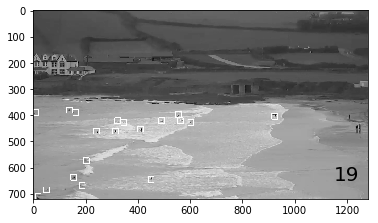

In [9]:
# Visualise results

# Grab corner coordinates of the bounding boxes
x1 = picks[:, 0]
y1 = picks[:, 1]
x2 = picks[:, 2]
y2 = picks[:, 3]

# Place rectangular markers around surfers
for i in range(0, len(x1)):
    # Width and height of box
    w = x2[i] - x1[i]
    h = y2[i] - y1[i]
    # Draw rectangle markers
    cv2.rectangle(img,(x1[i], y1[i]), ((x1[i]+w),
                 (y1[i]+h)), (255,0,0), 2)

# Show surfer numbers on plot
plt.text(1150, 650, str(count), fontsize=20)

# Save and show image
plt.imshow(np.array(img), cmap='gray')
plt.savefig('proto_output.jpg', dpi=300)